## Atomic systems (Netket)
Figuring out how to represent and optimize for ground states of atomic systems

In [1]:
# Can start with simple ansatz, just get the Hamiltonian right, and the fermion - boson stuff
import netket as nk
import netket.experimental as nkx
import jax.numpy as jnp

c:\Users\Parv\anaconda3\envs\jax_cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
# Hydrogen - 1 electron in atomic units
N = 1
#geo = nkx.geometry.FreeSpace(d=3)
hi = nk.hilbert.Particle(N=N, D=3, pbc=False)
sa = nk.sampler.MetropolisGaussian(hi, sigma=0.1, n_chains=16, sweep_size=32)

In [71]:
ekin = nk.operator.KineticEnergy(hi, mass=1.0)

def v(x):
    # electron nuclear, electron electron, nuclear nuclear
    return - 1/(jnp.linalg.norm(x))  # Centred at (0,0)

pot = nk.operator.PotentialEnergy(hi, v)

ha = ekin + pot

In [81]:
# Define Ansatz with two parameters - controlling Gaussian and the scaling

import flax.linen as nn
from flax import nnx
import jax
from flax.linen.dtypes import promote_dtype
from flax.linen.initializers import normal

from netket.utils.types import DType, Array, NNInitFunc


class Jastrow(nnx.Module):

    def __init__(self, *, rngs: nnx.Rngs):
        self.j1 = nnx.Param(0.01 * jax.random.normal(rngs.params(), (1,)), dtype=float)
        self.j2 = nnx.Param(0.01 * jax.random.normal(rngs.params(), (1,)), dtype=float)
        self.j3 = nnx.Param(0.01 * jax.random.normal(rngs.params(), (1,)), dtype=float)

    def __call__(self, x: jax.Array):
        # NN correlation
        norm_x = jnp.linalg.norm(x, axis=1)
        return jnp.exp(- self.j2 * norm_x) * self.j3

In [82]:
jas_model = Jastrow(rngs=nnx.Rngs(0))

In [83]:

vstate = nk.vqs.MCState(sa, jas_model, n_samples=512)

vstate.init_parameters()
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

gs = nk.driver.VMC(
    ha, optimizer, variational_state=vstate)


log = nk.logging.RuntimeLog()

In [84]:
vstate.expect_and_grad(ha)

(-0.319 ± 0.012 [σ²=0.068, R̂=1.2209],
 {'j1': Array([0.], dtype=float64),
  'j2': Array([-0.0130036], dtype=float64),
  'j3': Array([0.00968051], dtype=float64)})

In [85]:
gs.run(n_iter=20000, out=log)

 58%|█████▊    | 11510/20000 [02:17<01:41, 83.92it/s, Energy=-0.001859 ± 0.000028 [σ²=0.000000, R̂=1.4031]] 


KeyboardInterrupt: 

In [79]:
### Optimization loop

from tqdm import tqdm

energy_history = []
n_steps = 2000
lr = 0.05

for i in tqdm(range(n_steps)):
    E, E_grad = vstate.expect_and_grad(ha)
    energy_history.append(E.mean.real)

    new_pars = jax.tree_util.tree_map(
        lambda x, y: x - lr * y, vstate.parameters, E_grad
    )

    vstate.parameters = new_pars

100%|██████████| 2000/2000 [00:14<00:00, 139.02it/s]


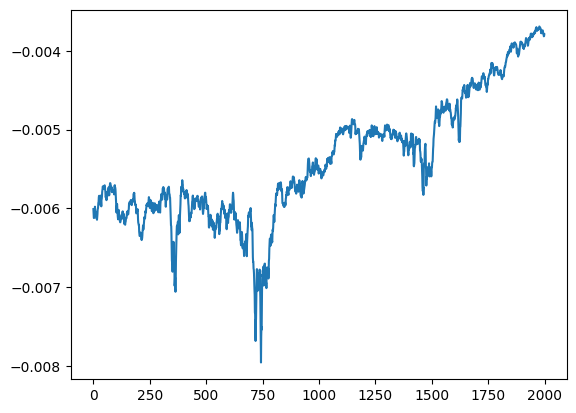

In [80]:
import matplotlib.pyplot as plt

plt.plot(energy_history)

Text(0.5, 1.0, 'Jastrow Ansatz')

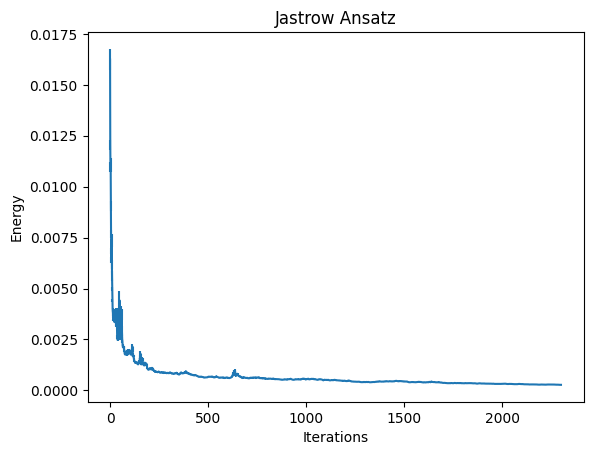

In [50]:
data_jastrow = log.data
plt.errorbar(
    data_jastrow["Energy"].iters,
    data_jastrow["Energy"].Mean,
    yerr=data_jastrow["Energy"].Sigma,
)


plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Jastrow Ansatz")